In [1]:
# Create a new notebook: 03_Baseline_Models.ipynb

# 1. Import necessary packages
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath('..'))  # Adjust if needed
from config.paths import *

print("Starting Phase 3: Baseline Models Implementation")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Ensured directory exists: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\data\processed
Ensured directory exists: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\results
Ensured directory exists: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\models
Starting Phase 3: Baseline Models Implementation


In [2]:

# 2. Load the graph dataset and extract features
graph_dataset_path = os.path.join(PROCESSED_DIR, 'oasis_graph_dataset.pt')
graph_list = torch.load(graph_dataset_path)

print(f"Loaded {len(graph_list)} graphs")

# Extract features and labels
X = []  # Feature vectors (flattened node features)
y = []  # Labels

for graph in graph_list:
    # Flatten the node features to create a feature vector
    features = graph.x.flatten().numpy()
    X.append(features)
    y.append(graph.y.item())

X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")


C:\Users\rakes\AppData\Local\Temp\ipykernel_26500\1132738710.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load(graph_dataset_path)


Loaded 416 graphs
Feature matrix shape: (416, 116)
Labels shape: (416,)
Class distribution: [316 100]


In [3]:

# 3. Preprocess the data
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
# 4. Define evaluation function
def evaluate_model(model, X_test, y_test, model_name=""):
    """Evaluate a model and return metrics"""
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    if model_name:
        print(f"{model_name} Results:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-score:  {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred
    }


In [5]:
# 5. Implement classical ML models
print("\nTraining Classical Machine Learning Models...")

# Initialize models
models = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Perform stratified k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    print(f"\nEvaluating {name} with {n_splits}-fold cross-validation...")
    
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y)):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Evaluate model
        metrics = evaluate_model(model, X_test, y_test)
        
        fold_accuracies.append(metrics['accuracy'])
        fold_precisions.append(metrics['precision'])
        fold_recalls.append(metrics['recall'])
        fold_f1s.append(metrics['f1'])
    
    # Store results
    results[name] = {
        'accuracy': (np.mean(fold_accuracies), np.std(fold_accuracies)),
        'precision': (np.mean(fold_precisions), np.std(fold_precisions)),
        'recall': (np.mean(fold_recalls), np.std(fold_recalls)),
        'f1': (np.mean(fold_f1s), np.std(fold_f1s))
    }
    
    print(f"{name} Average Performance:")
    print(f"  Accuracy:  {results[name]['accuracy'][0]:.4f} ± {results[name]['accuracy'][1]:.4f}")
    print(f"  Precision: {results[name]['precision'][0]:.4f} ± {results[name]['precision'][1]:.4f}")
    print(f"  Recall:    {results[name]['recall'][0]:.4f} ± {results[name]['recall'][1]:.4f}")
    print(f"  F1-score:  {results[name]['f1'][0]:.4f} ± {results[name]['f1'][1]:.4f}")



Training Classical Machine Learning Models...

Evaluating SVM with 5-fold cross-validation...
SVM Average Performance:
  Accuracy:  0.7933 ± 0.0229
  Precision: 0.6349 ± 0.0861
  Recall:    0.3500 ± 0.1049
  F1-score:  0.4411 ± 0.0896

Evaluating Random Forest with 5-fold cross-validation...
Random Forest Average Performance:
  Accuracy:  0.7934 ± 0.0247
  Precision: 0.6381 ± 0.1309
  Recall:    0.3800 ± 0.0678
  F1-score:  0.4675 ± 0.0588

Evaluating Logistic Regression with 5-fold cross-validation...
Logistic Regression Average Performance:
  Accuracy:  0.8054 ± 0.0390
  Precision: 0.6096 ± 0.1086
  Recall:    0.5500 ± 0.1095
  F1-score:  0.5740 ± 0.0934


In [6]:

# 6. Implement a simple MLP model
print("\nTraining Multi-Layer Perceptron (MLP) Model...")

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Prepare data for PyTorch
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.LongTensor(y)

# MLP training with cross-validation
mlp_accuracies = []
mlp_precisions = []
mlp_recalls = []
mlp_f1s = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"\nMLP Fold {fold+1}/{n_splits}")
    
    # Split data
    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Initialize model, loss, and optimizer
    model = MLP(input_dim=X.shape[1], hidden_dim=64, output_dim=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Training loop
    model.train()
    for epoch in range(100):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}/100, Loss: {epoch_loss/len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(batch_y.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    mlp_accuracies.append(accuracy)
    mlp_precisions.append(precision)
    mlp_recalls.append(recall)
    mlp_f1s.append(f1)
    
    print(f"  Fold {fold+1} Results: Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

# Store MLP results
results['MLP'] = {
    'accuracy': (np.mean(mlp_accuracies), np.std(mlp_accuracies)),
    'precision': (np.mean(mlp_precisions), np.std(mlp_precisions)),
    'recall': (np.mean(mlp_recalls), np.std(mlp_recalls)),
    'f1': (np.mean(mlp_f1s), np.std(mlp_f1s))
}

print(f"\nMLP Average Performance:")
print(f"  Accuracy:  {results['MLP']['accuracy'][0]:.4f} ± {results['MLP']['accuracy'][1]:.4f}")
print(f"  Precision: {results['MLP']['precision'][0]:.4f} ± {results['MLP']['precision'][1]:.4f}")
print(f"  Recall:    {results['MLP']['recall'][0]:.4f} ± {results['MLP']['recall'][1]:.4f}")
print(f"  F1-score:  {results['MLP']['f1'][0]:.4f} ± {results['MLP']['f1'][1]:.4f}")



Training Multi-Layer Perceptron (MLP) Model...

MLP Fold 1/5
  Epoch 20/100, Loss: 0.2823
  Epoch 40/100, Loss: 0.1117
  Epoch 60/100, Loss: 0.0733
  Epoch 80/100, Loss: 0.0243
  Epoch 100/100, Loss: 0.0328
  Fold 1 Results: Accuracy: 0.7143, F1: 0.3684

MLP Fold 2/5
  Epoch 20/100, Loss: 0.2186
  Epoch 40/100, Loss: 0.0925
  Epoch 60/100, Loss: 0.0708
  Epoch 80/100, Loss: 0.0298
  Epoch 100/100, Loss: 0.0284
  Fold 2 Results: Accuracy: 0.8434, F1: 0.7234

MLP Fold 3/5
  Epoch 20/100, Loss: 0.2742
  Epoch 40/100, Loss: 0.1621
  Epoch 60/100, Loss: 0.0890
  Epoch 80/100, Loss: 0.0551
  Epoch 100/100, Loss: 0.0323
  Fold 3 Results: Accuracy: 0.8193, F1: 0.5946

MLP Fold 4/5
  Epoch 20/100, Loss: 0.1532
  Epoch 40/100, Loss: 0.0859
  Epoch 60/100, Loss: 0.0237
  Epoch 80/100, Loss: 0.0194
  Epoch 100/100, Loss: 0.0128
  Fold 4 Results: Accuracy: 0.8193, F1: 0.6154

MLP Fold 5/5
  Epoch 20/100, Loss: 0.2331
  Epoch 40/100, Loss: 0.1342
  Epoch 60/100, Loss: 0.0797
  Epoch 80/100, Loss: 0


Creating visualizations...


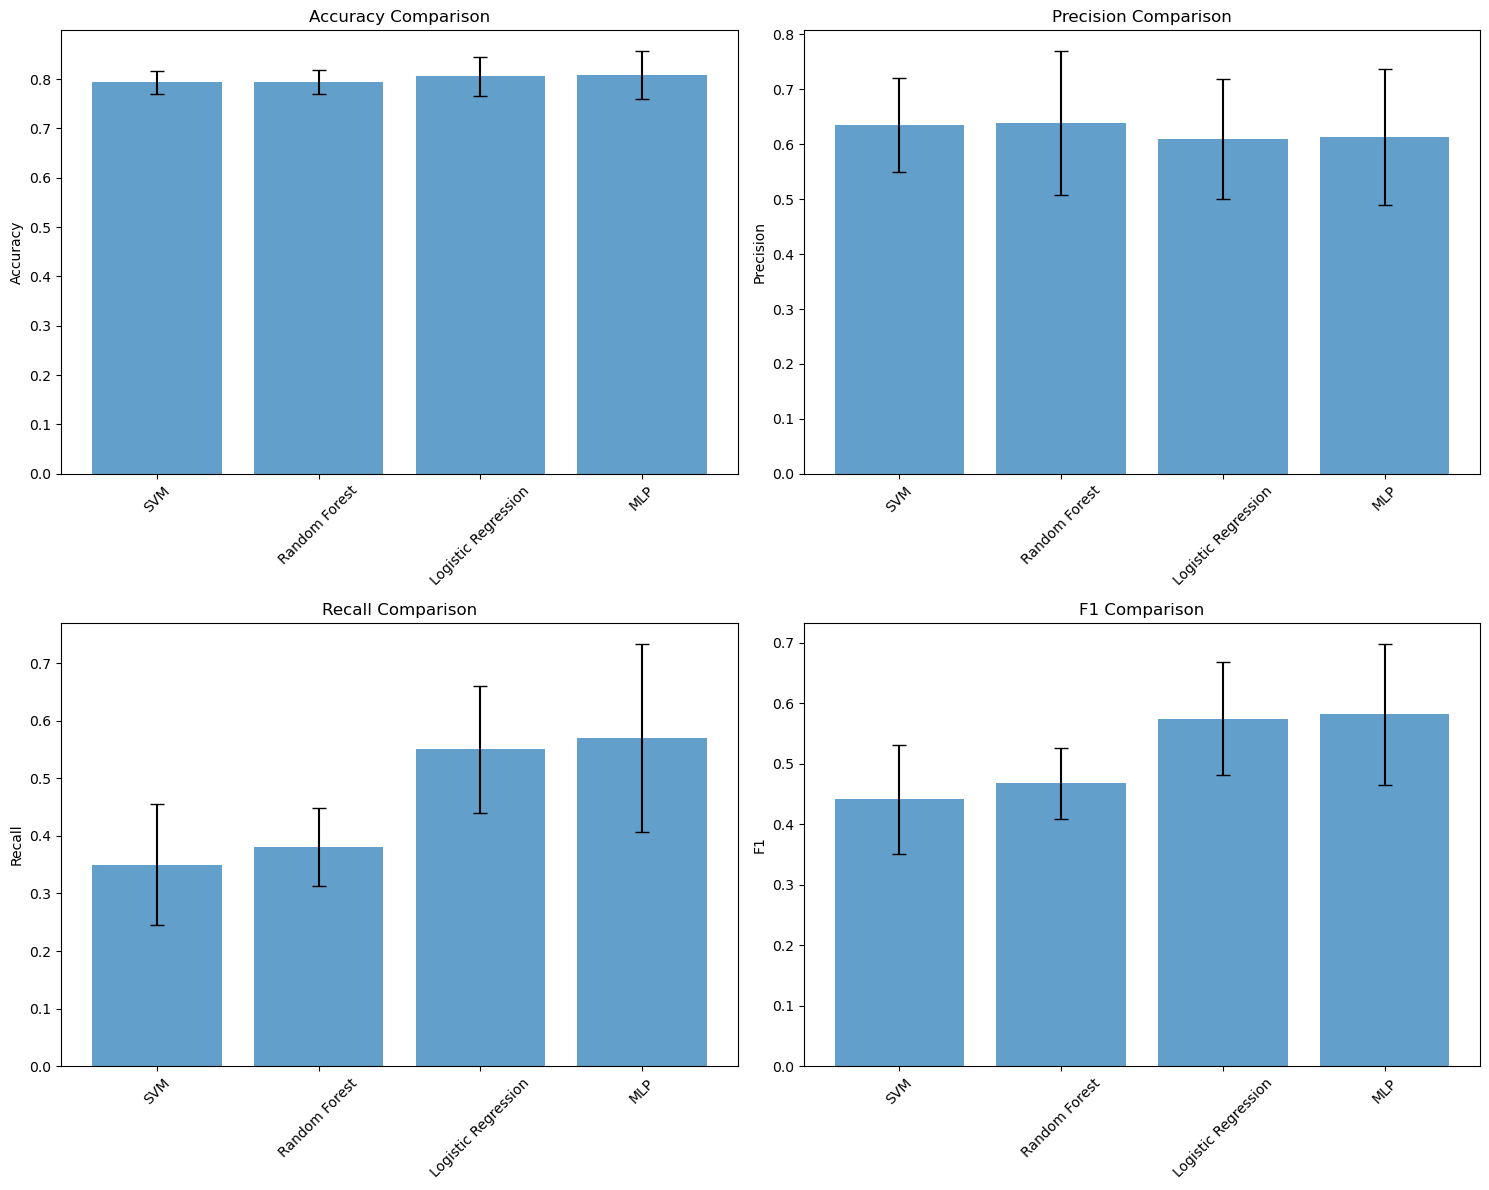


Creating confusion matrices...


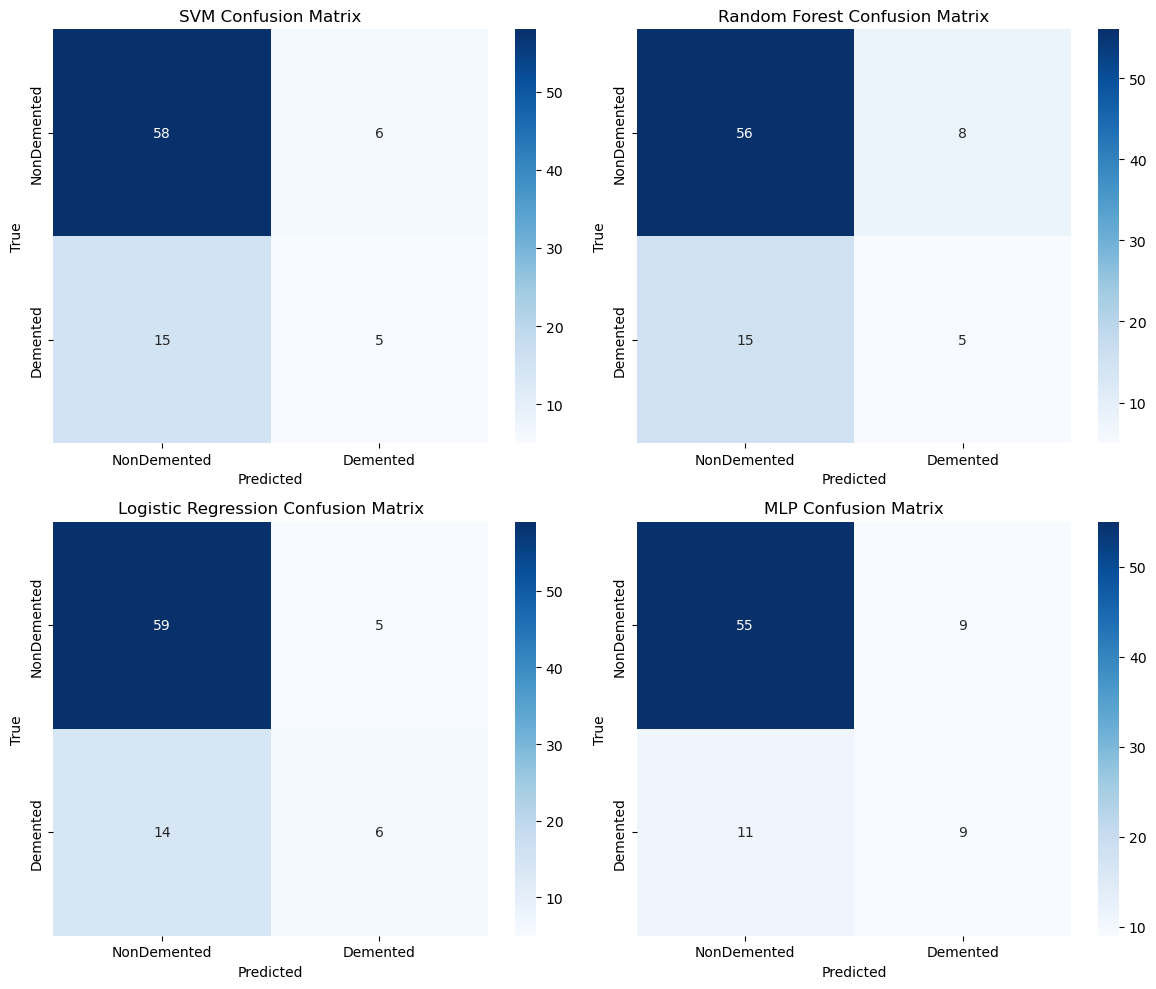

In [11]:
# 7b. Confusion Matrices
# 7. Visualize results
print("\nCreating visualizations...")

# Prepare data for plotting
model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Create a 2x2 grid for metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    means = [results[model][metric][0] for model in model_names]
    stds = [results[model][metric][1] for model in model_names]
    
    axes[i].bar(model_names, means, yerr=stds, capsize=5, alpha=0.7)
    axes[i].set_title(f'{metric.capitalize()} Comparison')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'baseline_models_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# 7b. Create confusion matrices for each model
print("\nCreating confusion matrices...")

# Train each model on a standard train-test split for consistent comparison
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Create a figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['NonDemented', 'Demented'],
                yticklabels=['NonDemented', 'Demented'])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# For MLP, we need to handle it separately
# Train MLP on the same split
mlp_model = MLP(input_dim=X.shape[1], hidden_dim=64, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)

# Train MLP
mlp_model.train()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = mlp_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate MLP
mlp_model.eval()
with torch.no_grad():
    outputs = mlp_model(X_test_tensor)
    _, y_pred_mlp = torch.max(outputs, 1)
    y_pred_mlp = y_pred_mlp.numpy()

# Create confusion matrix for MLP
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[3],
            xticklabels=['NonDemented', 'Demented'],
            yticklabels=['NonDemented', 'Demented'])
axes[3].set_title('MLP Confusion Matrix')
axes[3].set_xlabel('Predicted')
axes[3].set_ylabel('True')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'baseline_models_confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

# 8. Create a results table (continue with the rest of your code)...

In [8]:

# 8. Create a results table
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [f"{results[model]['accuracy'][0]:.4f} ± {results[model]['accuracy'][1]:.4f}" for model in model_names],
    'Precision': [f"{results[model]['precision'][0]:.4f} ± {results[model]['precision'][1]:.4f}" for model in model_names],
    'Recall': [f"{results[model]['recall'][0]:.4f} ± {results[model]['recall'][1]:.4f}" for model in model_names],
    'F1-score': [f"{results[model]['f1'][0]:.4f} ± {results[model]['f1'][1]:.4f}" for model in model_names]
})

print("\nResults Summary:")
print(results_df.to_string(index=False))

# Save results to CSV
results_csv_path = os.path.join(RESULTS_DIR, 'baseline_models_results.csv')
results_df.to_csv(results_csv_path, index=False)
print(f"\nResults saved to: {results_csv_path}")



Results Summary:
              Model        Accuracy       Precision          Recall        F1-score
                SVM 0.7933 ± 0.0229 0.6349 ± 0.0861 0.3500 ± 0.1049 0.4411 ± 0.0896
      Random Forest 0.7934 ± 0.0247 0.6381 ± 0.1309 0.3800 ± 0.0678 0.4675 ± 0.0588
Logistic Regression 0.8054 ± 0.0390 0.6096 ± 0.1086 0.5500 ± 0.1095 0.5740 ± 0.0934
                MLP 0.8079 ± 0.0480 0.6133 ± 0.1236 0.5700 ± 0.1631 0.5816 ± 0.1162

Results saved to: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\results\baseline_models_results.csv


In [9]:

# 9. Train final models on all data and save them
print("\nTraining final models on all data...")

final_models = {}

# Train classical models on all data
for name, model in models.items():
    model.fit(X_scaled, y)
    final_models[name] = model
    print(f"Trained final {name} model")

# Train MLP on all data
mlp_model = MLP(input_dim=X.shape[1], hidden_dim=64, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)

mlp_model.train()
for epoch in range(100):
    epoch_loss = 0
    for batch_x, batch_y in DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True):
        optimizer.zero_grad()
        outputs = mlp_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        print(f"MLP Epoch {epoch+1}/100, Loss: {epoch_loss/len(X_tensor):.4f}")

final_models['MLP'] = mlp_model
print("Trained final MLP model")


Training final models on all data...
Trained final SVM model
Trained final Random Forest model
Trained final Logistic Regression model
MLP Epoch 20/100, Loss: 0.0168
MLP Epoch 40/100, Loss: 0.0103
MLP Epoch 60/100, Loss: 0.0046
MLP Epoch 80/100, Loss: 0.0054
MLP Epoch 100/100, Loss: 0.0033
Trained final MLP model


In [10]:
# Save models
models_dir = os.path.join(MODELS_DIR, 'baseline_models')
os.makedirs(models_dir, exist_ok=True)

for name, model in final_models.items():
    if name == 'MLP':
        torch.save(model.state_dict(), os.path.join(models_dir, f'{name.lower().replace(" ", "_")}.pt'))
    else:
        import joblib
        joblib.dump(model, os.path.join(models_dir, f'{name.lower().replace(" ", "_")}.pkl'))
    
    print(f"Saved {name} model")

print("\n" + "="*60)
print("PHASE 3: BASELINE MODELS COMPLETE")
print("="*60)

Saved SVM model
Saved Random Forest model
Saved Logistic Regression model
Saved MLP model

PHASE 3: BASELINE MODELS COMPLETE
